--- 
Final project for the course in Computational Statistics | Summer 2021, M.Sc. Economics, Bonn University | [Jonathan Willnow](https://github.com/JonathanWillnow)


# Partitioning and Hierachical Clustering and their Validation <a class="tocSkip">   
    
    
---
      


Xu,D., Tian,Y. A comprehensive Survey of Clustering Algorithms, Ann. Data. Sci 2, 165-193 (2015)      Minhua Chen et al(2021): Deep Clustering with Measure Propagation


##### Downloading and viewing this notebook:

* To view this notebook, the best way is to download the notebook which is contained in the repository on [GitHub](https://github.com/OpenSourceEconomics/ose-data-science-course-project-JonathanWillnow). Other viewing options like _MyBinder_ or _NBViewer_ may have issues with displaying images or coloring of certain parts (missing images can be viewed in the folder [files](https://github.com/OpenSourceEconomics/ose-data-science-course-project-JonathanWillnow) on GitHub).




In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as tools
import scipy.stats as scipy
import sklearn.datasets as sk_data
import sklearn.cluster as sk_cluster
import sklearn_extra.cluster as skx_cluster
import sklearn.preprocessing as sk_preprocessing
import sklearn.metrics as sk_metrics
import random
import kneed


import time

from IPython.display import HTML

In [2]:
%matplotlib inline
#sns.set_context('talk')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 50, 'linewidths':0}

---
# Table of Contents
---

 1. [Introduction](#introduction)
 2. [The Tracking Underreported Financial Flows (TUFF) methodology](#section2)
 3. [Descriptive Statistics & Allocation of Chinese Development Finance](#section3)
   * 3.1 [The Distribution of Project Types](#section3.1)
   * 3.2 [Sectoral Distribution](#section3.2)  
   *  3.3 [Finance Form of Projects](#section3.3)  
   *  3.4 [Cross-country Distribution of Chinese Development Finance](#section3.4)  
   *  3.5 [Factors that determined Allocation of Chinese Development Finance](#section3.5)  
       *  3.5.1 [Extension - Descriptive Plots](#section3.5.1)  
       *  3.5.2 [Physical Project Inputs](#section3.5.2)  
       *  3.5.3 [Foreign Exchange Reserves](#section3.5.3)
   *  3.6 [Mixed Effect Models](#section3.6) 
 4. [Identification](#section4)
 5. [Empirical Strategy](#section5)
    *  5.1 [IV Strategy](#section5.1)
    *  5.2 [Checking Parallel Trends Assumption](#section5.2)
 6. [Does Chinese Development Finance Promote Growth?](#section6)
    *  6.1 [Main Results](#section5.1)
    *  6.2 [Extension - Visual Representation of Results](#section6.2)
    *  6.3 [ Extension - Checking Instrument Validity](#section6.3)
    *  6.4 [Timing of the Growth Effects](#section6.4)
    *  6.5 [How does Chinese Development Finance cause Growth?](#section6.5)
    *  6.6 [Robustness Checks](#section6.6)
 7. [Conclusion](#section7)
 8. [References and Literature](#section8)







# Introduction

Every day, large amounts of data are collected by many heterogenous individuals. To create information from this data, clustering is an essential part in the process to identify patterns or groups within the collected data, which poses special challenges: Unlike other methods in Data Science, clustering does not try to predict an output. We only observe the input variables, but not the output variable. 

Since choicde of feature types and measurement levels depends on the data, many clustering algorithms have been developed. 
https://www.intechopen.com/chapters/60501

I will explore several methods for partitioning and hierachical clustering and their validation. 

My simulation study will explain in which setup clustering methods works the most efficient and what kind of problems each method is facing / solving.


# 1. Clustering

Given by Marina:
The description should also include theoretical properties of the method together
with the properties of the data most often encountered in empirical settings. The
simulation study should reflect these two components. You may collaborate (i.e.
discuss) with other students who are working within the same general method, for
example, lasso, but everyone has to hand in an individual project


Clustering is often referred to as unsupervised machine larning. 

-------
Clusters are loosely defined as groups of data objects that are more similar to other objects in their cluster than they are to data objects in other clusters. In practice, clustering helps identify two qualities of data:

* Meaningfulness


* Usefulness

Meaningful clusters expand domain knowledge. For example, in the medical field, researchers applied clustering to gene expression experiments. The clustering results identified groups of patients who respond differently to medical treatments.
Useful clusters, on the other hand, serve as an intermediate step in a data pipeline. For example, businesses use clustering for customer segmentation. The clustering results segment customers into groups with similar purchase histories, which businesses can then use to create targeted advertising campaigns.

You can perform clustering using many different approaches—so many, in fact, that there are entire categories of clustering algorithms. Each of these categories has its own unique strengths and weaknesses. This means that certain clustering algorithms will result in more natural cluster assignments depending on the input data.
Selecting an appropriate clustering algorithm for your dataset is often difficult due to the number of choices available. Some important factors that affect this decision include the characteristics of the clusters, the features of the dataset, the number of outliers, and the number of data objects.
https://realpython.com/k-means-clustering-python/

Before jumping into the different algorithms for clustering, let us reconsider how to measure the distances of elements relative to each other in order to decide which elements belong in which group. A distance between any pair of elements or vectors satisfies four porperties:

1. Symmetrie, $d(i,j) = d(j,i)$
2. Poitive Definiteness, $d(i,j) > 0$ and $d(i,j) = 0$ if and only if $i=j$
3. Triangel Inequality, $d(i,j) <= d(i,k) + d(k,j)$

From these assumptions follows the Minkowskie distance, which is the traditional way to measure distances:

The Minkowski distance with order p between two elements (or vectors) $i,j$ is defined as:


\begin{equation}
D(i,j) = (|i - j|^p)^{(1/p)}
\end{equation}

taking $p$ as 1 $p$ = 1 we have the Manhattan distance, also know as taxi-cab distance and with $p$ = 2 we have the Euclidean distance. For most common hierachical clustering, the Euclidean distance is the go to distance.
http://i2pc.es/coss/Docencia/SignalProcessingReviews/Murtagh2012.pdf


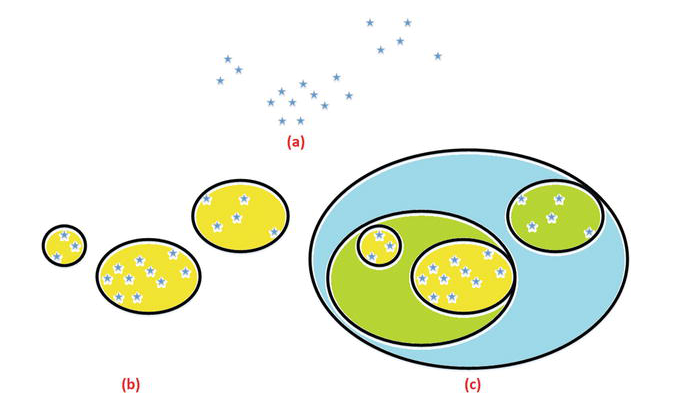
#### picture 1

https://www.intechopen.com/chapters/60501

Figure 1 display the difference between partitional clustering (b) and hierachical clustering (c) of a dataset (a) which we will explore in the following.


## Partitioning Clustering

Partitional clustering algorithms are methods used to classify data objects into multiple groups, with at minimum one element per group, based on their similarity. This is done in an intertive pocess. No object can be a member of more than one cluster. For some of theclustering algorithms of this categorie (K-Means, K-Medoids), the scientist has to specify $k$ - the number of clusters.

I will focus on four algorithms, K-Means clustering, K-Medoids clustering, Affinity Propagation Clustering, and Mean Shift clustering. Only Affinity Propagation is deterministic over runs. This simply means that when using the non-deterministic algorithms, the user could obtain different results when running the same algorithm several times over the same dataset.

Partitional clustering methods have several strengths:

+ They work well when clusters have a spherical shape.
+ They’re scalable with respect to algorithm complexity.

They also have several weaknesses:

+ They’re not well suited for clusters with complex shapes and different sizes.
+ They break down when used with clusters of different densities.
https://realpython.com/k-means-clustering-python/

## Data

For the following parts I created random samples using the scikit-learn function make_blobs(), which generates isotropic Gaussian blobs for clustering. The data needs to be standardized, since in a real world context the dataset would most likely contain features measured in different units.

In [3]:
random.seed(10)

In [4]:
features, true_labels = sk_data.make_blobs(n_samples=200, centers=3, cluster_std=2.75, random_state=42)
blobs_df = pd.DataFrame(features, columns = ["x1", "x2"])
blobs_df["label"] = true_labels
blobs_df.head(5)

x1         x2  label
0   9.770759   3.276210      1
1  -9.713497  11.274518      0
2  -6.913306  -9.347559      2
3 -10.861859 -10.750635      2
4  -8.500380  -4.543704      2

In [5]:
# Standartization
scaler = sk_preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features)
blobs_df = pd.DataFrame(features_scaled, columns = ["x1", "x2"])
blobs_df["label"] = true_labels
blobs_df.head(5)

x1        x2  label
0  2.130821  0.256044      1
1 -1.526985  1.410367      0
2 -1.001302 -1.565832      2
3 -1.742569 -1.768325      2
4 -1.299245 -0.872534      2

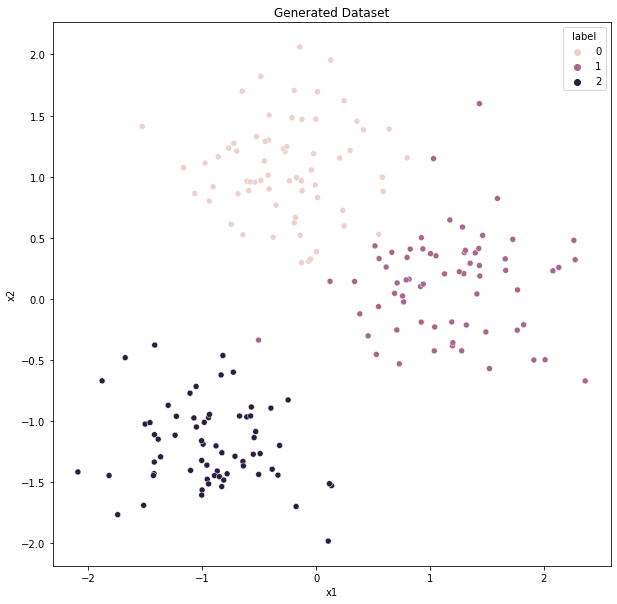

In [6]:
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.scatterplot(x= blobs_df.x1, y=blobs_df.x2, hue=blobs_df.label)
ax.set_title("Generated Dataset");

### K means

K-means clutering was introduced by J. MacQueen in 1967 when he was proposing algorithms that can "paritioning an N-dimensional population into k sets" (MacQueen 1967). According to MacQueen, this algorithm produces partitions that are reasonably efficient in their within-class variance, is easily implemented and not to computationally extensice. (MacQueen) In the following section we will see that this algorithm is scaling well to large number of samples.

As explained in Section 4, as a algorithm that is performing partitional clustering, the k-means algorithm clusters $n$ objects of the dataset $X$ by trying to partition them in $k$ groups $C$ of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. The so called cost function of the k-means algorithm is the follwing: C

\begin{equation}
\sum_{i=0}^n \min_{\mu_j \in C}(||{x_i}-{\mu_j}||^2)
\end{equation}

It is defines in terms of the squared euclidean distance of each point $x_i$ to the closest cluster mean.
MIT https://piazza.com/class_profile/get_resource/hckx35ial496d5/he8g2d4n99u6ic

This requires to specify the number of clusters. The inertia criterion leads to the algorithm suffering regarding several drawbacks:
* Inertia assumes that true clusters are convex and isotropic. So it assumes globular clusters, whereas in reality this is not always the case. It is therefore not suitable for clusters with unusual shapes.

* Inertia is not normalized, meaning that we just know that a Inertia of 0 is optimal, but we cannot compare the inertia that we obtained by k-means clustering across several datasets. This is especially true for the high dimensional space, where the euclidean distance becomes inflated when the algorithm tries to learn the structur of a high dimensional dataset from a small number of observations.
https://scikit-learn.org/stable/modules/clustering.html#


Given a specified inital set of k-means $m_1$,...$m_k$, Lloyds algorithm proceeds as follows:

---
<span style="color:blue">**Llyods algorithm**:</span> 

   1. **Initialization**: The initial k-centroids are randomly picked from the dataset
   2. **Assignment**: For each point in the dataset, find the euclidean distance between the point and all centroids
   3. **Updating**: Update the value of the centroid with the new mean value
   4. **Repeat**: Repeat steps 2 and 3 until convergence is archieved. The break the loop

---
https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca




## K Medoids

K-Medoids clustering tackles a problem of K-Means clustering: IN K-Means Clustering, the final centroids are not interpretable since these centroids are not actuall points but the mean of all the points that were partitioned into that cluster. Therefore the coordinates of the centroids do not resemlbe reals points. K-Medoids clustering tackles this and makes the final centroids actual datapoints, which makes the final centroid intertrepatble.

The algorithm used for k-medoids clusterig is called the Partitioning Around Medoids Algorithm (PAM). It uses a greedy search which may not reuslt in the optimum solution, but is really fast. PAM proceeds as follows:

---
<span style="color:blue">**Partitioning Around Medoids Algorithm (PAM)**:</span> 

   1. **Initialization**: The initial k-medoids are randomly picked from the dataset
   2. **Assignment**: For each point in the dataset, find the euclidean distance between the point and all medoids and associate each point to the closest medoid
   3. **Updating**: Choose new centroid $M$ such that it minimizes the minimum cost function:

\begin{equation}
M_1, M_2, ..., M_k = argmin \sum_{i=1}^k \sum_{i=1} ||x-M_i||^2)
\end{equation}

   4. **Repeat**: Repeat steps 2 and 3 until convergence is archieved. The break the loop

---

https://piazza.com/class_profile/get_resource/hckx35ial496d5/he8g2d4n99u6ic

https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca

or in other words, centroids are not the actual point but the mean of points present in that cluster. Here are the coordinates of 3-centroids that do not resemble real points from the dataset.

## Choosing the Appropriate Number of Clusters
In this section, you’ll look at two methods that are commonly used to evaluate the appropriate number of clusters:
https://realpython.com/k-means-clustering-python/

### The elbow method


These are often used as complementary evaluation techniques rather than one being preferred over the other. To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE. Determining the elbow point in the SSE curve isn’t always straightforward. Therefore I use a Python package, kneed, to identify the elbow point programmatically:
https://realpython.com/k-means-clustering-python/


### The silhouette coefficient

The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

How close the data point is to other points in the cluster
How far away the data point is from points in other clusters
Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In the scikit-learn implementation of the silhouette coefficient, the average silhouette coefficient of all the samples is summarized into one score. The silhouette score() function needs a minimum of two clusters, or it will raise an exception.

Loop through values of k again. This time, instead of computing SSE, compute the silhouette coefficient:
https://realpython.com/k-means-clustering-python/

The following function performs k-means clustering and uses both methods to evaluate the appropriate cluster based on different generated datasets:

In [7]:
# Data generation
features, true_labels = sk_data.make_blobs(n_samples=200, centers=3, cluster_std=2.75, random_state=42)
scaler = sk_preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(features)


In [8]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42,}

In [9]:
def kmeans(kmeans_kwargs, kmax, centers, cluster_std):
    
   # Data generation
    features, true_labels = sk_data.make_blobs(n_samples=200, centers=centers, cluster_std=cluster_std, random_state=42)
    scaler = sk_preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(features)
    #scaled_features_2 = scaler.fit_transform(df[["x1","x2"]])
    sse = []
    for k in range(1, kmax):
        kmeans = sk_cluster.KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)


    kl = kneed.KneeLocator(range(1, kmax), sse, curve="convex", direction="decreasing")
    kl.elbow
    
    silhouette_coef = []
    for k in range(2, kmax):
        kmeans = sk_cluster.KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        score = round(sk_metrics.silhouette_score(scaled_features, kmeans.labels_),4)
        silhouette_coef.append(score)
        
    max_score = max(silhouette_coef)
    best_k = 2+silhouette_coef.index(max_score)

        
    
    fig, ax = plt.subplots(1,2, figsize = (10,5))
   
    plt.subplot(121)
    ax = sns.lineplot(x= range(1,kmax),y=sse)
    ax1 = plt.axvline(x=kl.elbow, animated = True, ls = "--", c = "red")
    ax.set_ylabel("SSE")
    ax.set_xlabel("number of clusters")
    ax.set_title("Ellbow Method");    

    plt.subplot(122)
    ax = sns.lineplot(x=range(2,kmax), y=silhouette_coef)
    ax1 = plt.axvline(x=best_k, animated = True, ls = "--", c = "red")
    ax.set_ylabel("SSE")
    ax.set_xlabel("number of clusters")
    ax.set_title("Silhouette Coefficient");
    fig.suptitle(f"k-means, Specifications: Centers: {centers}, Cluster std.: {cluster_std}", fontsize=16)
    plt.tight_layout(pad=2.5);



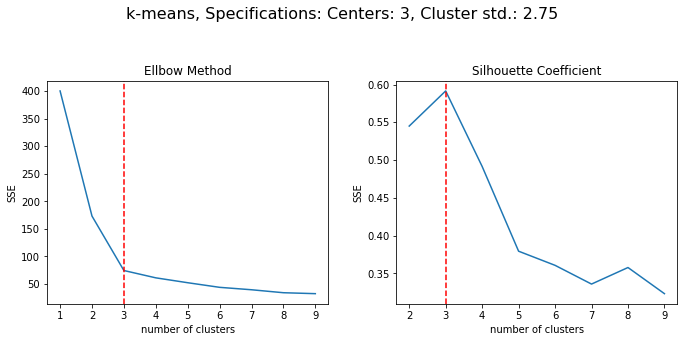

In [10]:
kmeans(kmeans_kwargs, 10, 3, 2.75);
   

https://realpython.com/k-means-clustering-python/

https://scikit-learn-extra.readthedocs.io/en/stable/modules/cluster.html#k-medoids

In [11]:
kmedoids_kwargs = { "init": "random", "max_iter": 300, "random_state": 42,}

In [12]:
def kmedoids(kmedoids_kwargs, kmax, centers, cluster_std):
   
    # Data generation
    features, true_labels = sk_data.make_blobs(n_samples=200, centers=centers, cluster_std=cluster_std, random_state=42)
    scaler = sk_preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(features)
    #scaled_features_2 = scaler.fit_transform(df[["x1","x2"]])
    sse = []
    
    for k in range(1, kmax):
        kmedoids = skx_cluster.KMedoids(n_clusters=k, **kmedoids_kwargs)
        kmedoids.fit(scaled_features)
        #print("for k: ", k, ((true_labels != kmedoids.labels_).sum())**2 / len(true_labels))
        sse.append(kmedoids.inertia_)


    kl = kneed.KneeLocator(range(1, kmax), sse, curve="convex", direction="decreasing")
    kl.elbow
    
    silhouette_coef = []
    for k in range(2, kmax):
        kmedoids = skx_cluster.KMedoids(n_clusters=k, **kmedoids_kwargs)
        kmedoids.fit(scaled_features)
        score = round(sk_metrics.silhouette_score(scaled_features, kmedoids.labels_),4)
        silhouette_coef.append(score)
        
    max_score = max(silhouette_coef)
    best_k = 2+silhouette_coef.index(max_score)

        
    
    fig, ax = plt.subplots(1,2, figsize = (10,5))

    plt.subplot(121)
    ax = sns.lineplot(x= range(1,kmax),y=sse)
    ax1 = plt.axvline(x=kl.elbow, animated = True, ls = "--", c = "red")
    ax.set_ylabel("SSE")
    ax.set_xlabel("number of clusters")
    ax.set_title("Ellbow Method");    

    plt.subplot(122)
    ax = sns.lineplot(x=range(2,kmax), y=silhouette_coef)
    ax1 = plt.axvline(x=best_k, animated = True, ls = "--", c = "red")
    ax.set_ylabel("SSE")
    ax.set_xlabel("number of clusters")
    ax.set_title("Silhouette Method");
    fig.suptitle(f"k-medoids, Specifications: Centers: {centers}, Cluster std.: {cluster_std}", fontsize=16)
    plt.tight_layout(pad=2.5);

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(


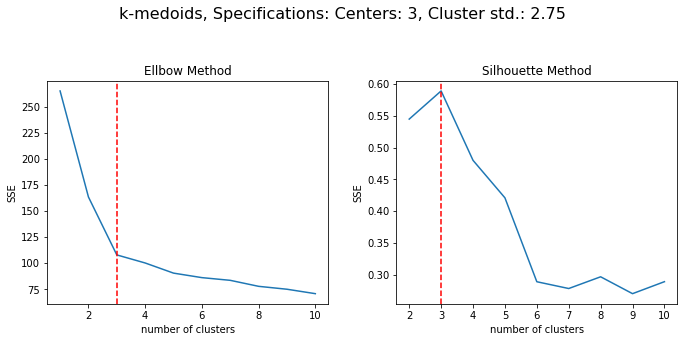

In [13]:
kmedoids(kmedoids_kwargs, 11, 3,2.75)

In [14]:
### https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    #palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    #colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    results = pd.DataFrame(data, columns = ["x1", "x2"])
    results["labels"] = labels
    
    fig, ax = plt.subplots(figsize = (10,10))
    ax = sns.scatterplot(x=results.x1, y=results.x2, hue = labels)
    #plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    #frame = plt.gca()
    #frame.axes.get_xaxis().set_visible(False)
    #frame.axes.get_yaxis().set_visible(False)
    ax.set_title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return(labels)

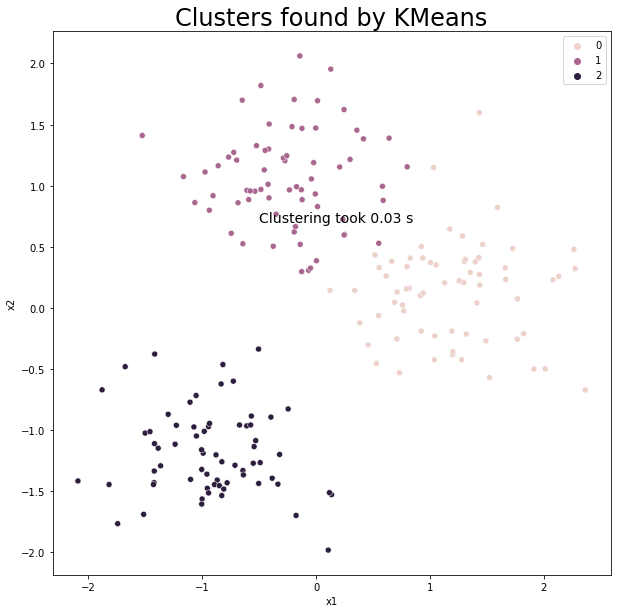

In [15]:
xx = plot_clusters(blobs_df, sk_cluster.KMeans, (), {'n_clusters':3,  "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42})


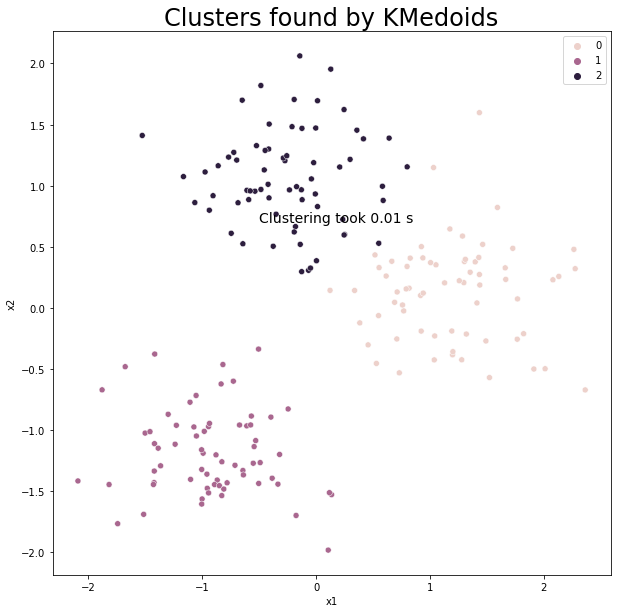

In [16]:
xx = plot_clusters(blobs_df, skx_cluster.KMedoids, (), {'n_clusters':3,  "init": "random", "max_iter": 300, "random_state": 42})

## Affinity Propagation

Affinity Propagation is a newer and modern clustering algorithm that uses a graph based approach. It aims to discover the datappoints taht represent the whole dataset. This is done since the algorithm let the points ‘vote’ themselves on their preferred ‘exemplar’ based on the maximal value of the responsibility and availability of each data point. Responsibility of a data point refers to wheter it is suited to be assigned to an exemplar; Availability measures how well a data point is suiteed to be an exemplar.

https://digitalcommons.georgiasouthern.edu/cgi/viewcontent.cgi?article=3029&context=etd

This is done by passing messages between the data points until these maximums are archieved. We do not need to specify $k$ since the optimal number of clusters is computed through updating the responsibility and availability of all data points of the dataset. The algorithm then returns data points as a set of ‘exemplars’ from which the clusters are then created similar to what K-Means does: Each point is assigned to the cluster of it’s nearest exemplar. 
https://digitalcommons.georgiasouthern.edu/cgi/viewcontent.cgi?article=3029&context=etd

Affinity Propagation has some advantages over K-Means:

* First, since the points vote themselves on their preferred exemplars, the user doesn’t need to specify the number of clusters. 

* Second, the algorithm allows for non-metric dissimilarities which is important if the user wants to work with data that is not naturally embedded in a metric space

* Finally, Affinity Propagation offers better stability runs

Since Affinity Propagation partitions the data, problems with 'noisy' data can be expected. In addition to this, Affinity Propagations needs the user to specify 'preference' and 'damping' parameters, which can be challenging. Additionally, since the algorithm supports non-metric dissimilarities, it tends to be slow. Overall, Affinity Propagation does not really provide an improvement in normal settings unless the choice of the specific preference and damping parameters are easier than specify the number of clusters.
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#

Because the algorithm works without specifying $k$ initial clusters, there is no application for the elbow and silhouette method.
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#mean-shift

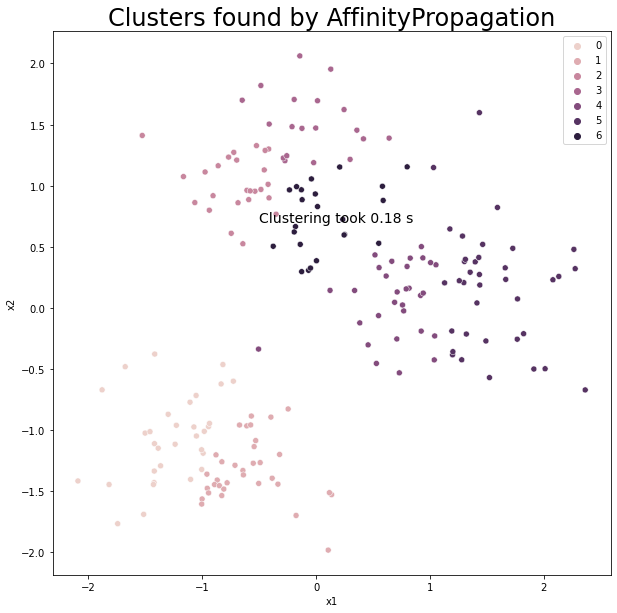

In [17]:
xx= plot_clusters(blobs_df, sk_cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95, "max_iter": 400, "random_state": 42})

cluster_allbool, default=True
If true, then all points are clustered, even those orphans that are not within any kernel. Orphans are assigned to the nearest kernel. If false, then orphans are given cluster label -1.

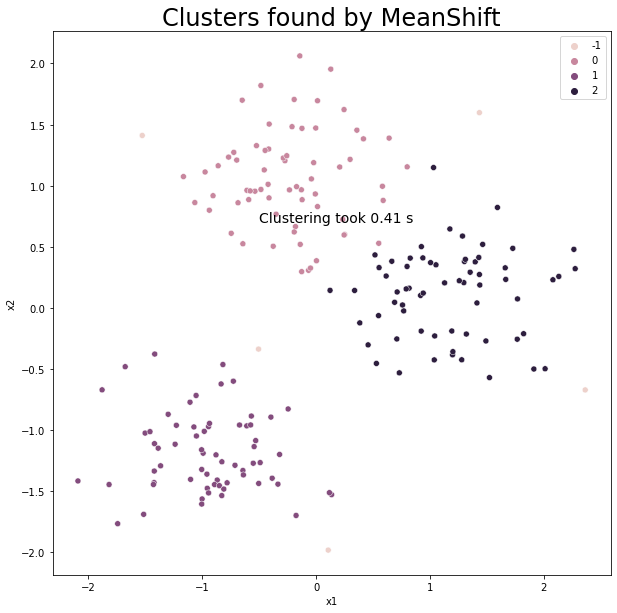

In [18]:
xxx= plot_clusters(blobs_df, sk_cluster.MeanShift, {}, {'cluster_all':False});

## Hierachial Clustering

Hierarchical clustering determines cluster assignments by building a hierarchy. The data is first clustered in some subgroups. This is implemented by either a bottom-up or a top-down approach. There are two families of hierachical clustering algorithms:

* Agglomerative clustering is the bottom-up approach as one moves up in the hierachy. It merges the two points that are the most similar until all points have been merged into a single cluster or the desired number of clusters is obtained.

---
<span style="color:blue">**Agglomerative Clustering**:</span> 

   1. All data points are in their own cluster
   2. Two nearest clusters are joined to form single cluster
   3. Repeat step 2 until until desired number of clusters is obtained

---

* Divisive clustering is the top-down approach. It starts with all points as one cluster and splits the least similar clusters at each step until only single data points remain.

---
<span style="color:blue">**Divisive Clustering**:</span> 

   1. All data points are assigne in one singel cluster
   2. Cluster is partitioned into two least similar clusters
   3. Repeat step 2 to form new clusters until desired number of clusters is obtained

---
The algorithms of the families differ in their linkage criterion. 
https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-hierarchical-clustering

## continue

In the following I will focus on the family of Agglomerativ Clustering algorithms, since I did not found a function that performs Divisive Clustering in Python.



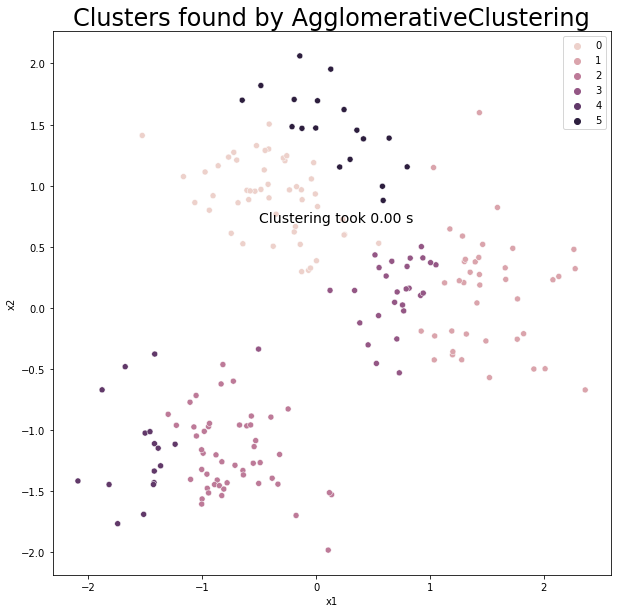

In [19]:
AgglomarativeClusters = plot_clusters(blobs_df, sk_cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

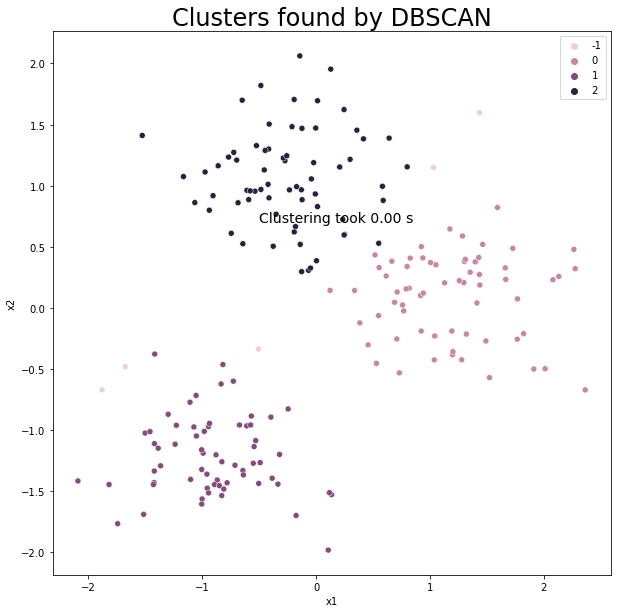

In [20]:
DBSCANClusters = plot_clusters(blobs_df, sk_cluster.DBSCAN, (), {'eps':0.5})

 Noisy samples are given the label -1.

## Performance and Scaling

So far I described several clustering algorithms. This ection will shed light on the issue of performance and scalability. Some might thik tht this topic does not really matter nowadays, but as I will show, it still does for some algorithms that we discussed. 

Performance and Scalability depends both on the algorithm itself, but also on the implementation. Obviously a well written implementation in C or C++ will beat my implementation with Pyton. But besides the choice of the language that we use, there are other factors that have a large impact on the performance. The structure of the dataset at hand impacts the performance by a large amount, and can even significanty change asymptotic performance. So for some researchers with limited computational resources or for Data Scientist that have to process hugh amounts of data everyday, this poses a serious constraint to the range of clustering algorithms that are feasible for them.

To provide a comparison of the clustering algorithms with regard to the performance and scaleability, I coded a benchmarking function that gives us the performance for each algorithm with varying dataset sizes. Because some clustering algorithms have performance that can vary quite a lot depending on the exact nature of the dataset we’ll also need to run several times on randomly generated datasets of each size so as to get a better idea of the average case performance.----


In [21]:
dataset_sizes = np.hstack([np.arange(1, 4) * 500])#, np.arange(3,7) * 1000, np.arange(4,10) * 2000])
dataset_sizes

array([ 500, 1000, 1500])

In [22]:
def benchmark_algorithm(dataset_sizes, cluster_function, function_args, function_kwds,
                        dataset_dimension=10, dataset_n_clusters=10, max_time=45, sample_size=2):

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = pd.DataFrame(np.nan * np.ones((len(dataset_sizes), sample_size)), columns = ["nobs","time"])
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sk_data.make_blobs(n_samples=size,
                                                       n_features=dataset_dimension,
                                                       centers=dataset_n_clusters)

            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time
            
            # create list to temporarily store results
            h_result = []
            h_result.append(time_taken)
            
        # calculate mean of time taken and add to result DataFRame
        result.loc[index, "time"] = (sum(h_result)/len(h_result))
        result.loc[index, "nobs"] = size

    # Return the result as a dataframe for easier handling with seaborn afterwards
    #return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                  # result.flatten()]).T, columns=['x','y'])
    return(result)

In [23]:
kwargs_random = {"random_state": 42}

In [24]:
k_means = sk_cluster.KMeans(10, **kwargs_random)
k_means_data = benchmark_algorithm(dataset_sizes, k_means.fit, (), {})

mean_shift = sk_cluster.MeanShift(10)
mean_shift_data = benchmark_algorithm(dataset_sizes, mean_shift.fit, (), {})

affinity_propagation = sk_cluster.AffinityPropagation(**kwargs_random);
affinity_propagation_data = benchmark_algorithm(dataset_sizes, affinity_propagation.fit, (), {});

agglomarative_clustering = sk_cluster.AgglomerativeClustering();
agglomarative_clustering_data = benchmark_algorithm(dataset_sizes, agglomarative_clustering.fit, (), {});

dbscan = sk_cluster.DBSCAN()
dbscan_data = benchmark_algorithm(dataset_sizes, dbscan.fit, (), {})



#labels = algorithm(*args, **kwds).fit_predict(data)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass bandwidth=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


In [25]:
agglomarative_clustering_data

nobs      time
0   500.0  0.004986
1  1000.0  0.022939
2  1500.0  0.057845

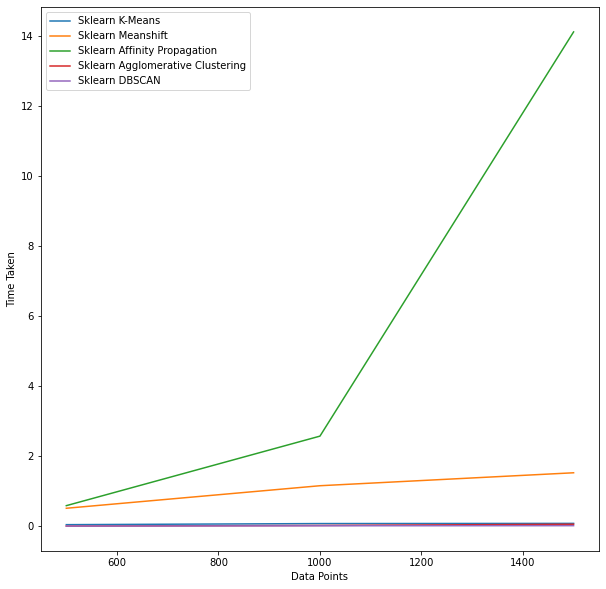

In [26]:
fig,ax = plt.subplots(figsize = (10,10))
ax = sns.lineplot(x= 'nobs', y='time', data=k_means_data, label='Sklearn K-Means')
ax = sns.lineplot(x= 'nobs', y='time', data=mean_shift_data, label='Sklearn Meanshift')
ax = sns.lineplot(x= 'nobs', y='time', data=affinity_propagation_data, label='Sklearn Affinity Propagation')
ax = sns.lineplot(x= 'nobs', y='time', data=agglomarative_clustering_data, label='Sklearn Agglomerative Clustering')
ax = sns.lineplot(x= 'nobs', y='time', data=dbscan_data, label='Sklearn DBSCAN')
ax.set_xlabel("Data Points")
ax.set_ylabel("Time Taken")
plt.plot();


## Validation

# Simulation Study

# Empirical Application

### Literature

(MacQueen 1967)(https://projecteuclid.org/ebooks/berkeley-symposium-on-mathematical-statistics-and-probability/Proceedings%20of%20the%20Fifth%20Berkeley%20Symposium%20on%20Mathematical%20Statistics%20and%20Probability,%20Volume%201:%20Statistics/chapter/Some%20methods%20for%20classification%20and%20analysis%20of%20multivariate%20observations/bsmsp/1200512992)
